# Deep Learning Projekt: Eckenerkennung von Gaszähler Auslesefeld 
In dem Projekt soll ein CNN erstellt werden zur Eckerkennung von Auslesefeldern eines Gaszählers. Das Problem liegt darin, dass die Bilder nicht gleich sind und sich die Eckpunkte immer verändern, in Bezug auf ihre Pixelkoordinaten. Das Modell ist Interessant wenn man das Auslesen des Zählerstandes aus Sicht großer Gasanbieter betrachtet. Es gibt mittlerweile bei vielen Anbietern (bspw. EON) die Möglichkeit den Zählerstand per Foto mitzuteilen. Diese Bilder werden immer  unterschiedliche Formate, Belichtungsbedingungen und Aufnahmeperspektiven haben, so dass das Auslesefeld immer anders im Bild dargestellt sein wird. Um die Auswertung dieser ganzen Bilder zu automatisieren bietet sich das Modell bestens an. Unser Modell kann die Eckpunkte des Auslesefeldes lokalisieren, dies dient als Grundlage für die Problemlösung. 

#### Mögliche Erweiterung:
Das Programm kann noch erweitert werden für das ausschneiden des Auslesefeldes aus dem bestehenden Bild, möglicher Entzerrung (falls das Bild aus einem spitzen Winkel aufgenommen wurde) und mit anschließender Standardisierung bezüglich Format, Helligkeit und Auflösung. Nach dieser Standardisierung könnte eine Zahlenfeld Detektion implementiert werden aus dem anschließend die Zahl erkannt wird. 

## Datensatz und Aufbereitung
Der benutzte Datensatz hat eine größe von 14421 Daten. Er besteht aus Bildern, welche als Inputdaten dienen und aus Json-Dateien als Labels, in denen die Koordinaten der Eckpunkte hinterlegt sind. Die Bilder werden aufgeteilt in Trainingsdaten mit 14321 Bildern und Trainingsdaten mit 100 Bildern. Der gesamte Datensatz wurde von Herrn Prof. von Marcard zur Verfügung gestellt und ist nicht öffentlich verfügbar.
### Inputdaten:
Bei den Inputdaten handelt es sich um Bilder. Das Originalformat beträgt 480x720 Pixel, jedoch werden die Bilder zur Effizienzsteigerung des Trainings auf 96x144 Pixel herunter skaliert (Faktor 0.2) und eine Normalisierung durchgeführt. Da die Bilder eine große ähnlichkeit aufweisen wird eine zufällige Augmentierung durchgeführt. Dies schützt vor Overfitting und macht das Modell robuster. Außerdem wird der Datensatz dadurch künstlich vergrößert.
### Labels:
Die Labels stehen ursprünglich als Json-Datei zur Verfügung, in denen die Pixelkoordinaten der Eckpunkte hinterlegt werden. Für ein einfacheres Handling werden jedoch Heatmaps aus ihnen erstellt. Die Heatmaps werden direkt im Format 96x144 Pixel erstellt. Dafür werden die Koordinatenpunkte mit dem Faktor 0.2 skaliert. Die Labelkoordinaten erhalten den Wahrscheinlichkeitswert 1, anschließend wird eine Gausverteilung über die Heatmap gelegt, für eine größen Bereich mit Werten größer als Null. Dies schaft einen glatteren Übergang und hilft dem Modell zu lernen (Förderung von weichen Entscheidungen, Bessere Annäherung an reale Datenverteilungen etc.). Die Heatmaps werden wie Bilder behandelt das sorgt für eine deutliche Vereinfacherung bei der Augmentierung, da neue Pixelkoordinaten nich kompliziert berechnet werden müssen. Die Augmentierung findet parallel mit den dazugehörigen Bildern statt, damit die gleichen Augmentierungen stattfinden und der Zusammenhang von bild und Label erhalten bleiben.
### Umsetzung:
Die Umsetzung findet mit den Funktionen _create_heatmap_ zum erzeugen der Heatmaps statt und _create_dataset_. In _create_heatmap_ werden lediglich die skalierten Label Heatmaps erzeugt. In _create_dataset_ werden die Datasets erstellt mit den Funktionen zum shufflen, zur Augmentierung und Verknüpfung von Bild mit richtigem Label.


In [63]:
import tensorflow as tf
import numpy as np
import json
import random
import os
from scipy.ndimage import gaussian_filter
from keras import layers, models
import matplotlib.pyplot as plt
import tensorflow_addons as tfa


# Heatmap-Generierung
def generate_heatmap(corners, image_size, sigma=0.5):
    """
    Erzeugt eine Heatmap mit einem Gauß um einen Punkt.
    :param image_size: Tuple der Form (Höhe, Breite)
    :param point: Tuple (x, y) der Punktkoordinaten
    :param sigma: Standardabweichung für den Gauß
    :return: Heatmap (Höhe x Breite)
    """
    # Heatmap initialisieren
    heatmap = np.zeros(image_size, dtype=np.float32)

    # Setze den Punkt in der Heatmap
    for corner in corners:
        # Überprüfe Grenzwerte, um Fehler zu vermeiden
        corner[0] = min(max(corner[0], 0), image_size[1] - 1)  # Breite
        corner[1] = min(max(corner[1], 0), image_size[0] - 1)  # Höhe

        heatmap[corner[1], corner[0]] = 1  # Beachte (y, x)-Reihenfolge

    # Gaußfilter anwenden
    return gaussian_filter(heatmap, sigma=sigma)


# JSON-Labels parsen
def parse_json(json_path):
    """
    Liest die Ecken aus einer JSON-Datei.
    :param json_path: Pfad zur JSON-Datei
    :return: Liste der Punkte [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
    """
    with open(json_path, "r") as f:
        data = json.load(f)
        polygon_points = data["shapes"][0]["points"]

    return [(int(pt[0]), int(pt[1])) for pt in polygon_points]


# Bild- und Label-Laden
def load_data(image_path, json_path, image_size=(96, 144), scale=0.2):
    """
    Lädt ein Bild und erzeugt Heatmaps für die Ecken.
    :param image_path: Pfad zum Bild
    :param json_path: Pfad zur JSON-Datei
    :param image_size: Zielgröße für die Bilder (Höhe, Breite)
    :return: Bild und Heatmaps als Tensoren
    """

    # Bild laden und skalieren
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    # print((int(image_size[0]*scale),int(image_size[1]*scale)))
    image = tf.image.resize(image, image_size)
    # image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32) / 255.0  # Normierung

    # Labels (Heatmaps) erstellen
    corners = np.array(parse_json(json_path.numpy().decode()))
    for corner in corners:
        corner[0] *= scale
        corner[1] *= scale

    heatmaps = generate_heatmap(corners, image_size)
    return image, heatmaps


# Dataset-Erstellung
def create_dataset(
    image_dir, json_dir, batch_size=2, image_size=(96, 144), scale=0.2, shuffle=True
):
    """
    Erstellt ein tf.data.Dataset für Bilder und Heatmaps mit Augmentierung.
    :param image_dir: Verzeichnis mit Bildern
    :param json_dir: Verzeichnis mit JSON-Dateien
    :param batch_size: Batch-Größe
    :param image_size: Zielgröße der Bilder
    :param shuffle: Ob die Daten vor dem Batchen gemischt werden sollen
    :return: tf.data.Dataset
    """
    # Pfade zu Bildern und JSON-Dateien sammeln
    image_paths = sorted(
        [
            os.path.join(image_dir, fname)
            for fname in os.listdir(image_dir)
            if fname.endswith(".jpg")
        ]  # Nur .jpg Bilder
    )
    json_paths = sorted(
        [
            os.path.join(json_dir, fname)
            for fname in os.listdir(json_dir)
            if fname.endswith(".json")
        ]  # Nur .json Dateien
    )

    print(f"Anzahl der Bilder: {len(image_paths)}")  # Anzahl der Bilder überprüfen
    print(
        f"Anzahl der JSON-Dateien: {len(json_paths)}"
    )  # Anzahl der JSON-Dateien überprüfen
    # Pfade zu Bildern und JSON-Dateien sammeln
    image_paths = sorted(
        [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
    )
    json_paths = sorted(
        [os.path.join(json_dir, fname) for fname in os.listdir(json_dir)]
    )

    # Dataset mit Pfaden erstellen
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, json_paths))

    if shuffle:
        dataset = dataset.shuffle(
            buffer_size=len(image_paths), reshuffle_each_iteration=True
        )

    # Prozessierungsfunktion definieren
    def process_paths(image_path, json_path):
        image, heatmaps = tf.py_function(
            func=load_data,
            inp=[image_path, json_path, image_size, scale],
            Tout=(tf.float32, tf.float32),
        )
        image.set_shape([96, 144, 3])  # Setze die erwartete Form für das Bild
        heatmaps.set_shape([96, 144])  # Anzahl der Ecken (Anzahl der Kanäle)
        return image, heatmaps

    dataset = dataset.map(process_paths, num_parallel_calls=tf.data.AUTOTUNE)

    # Augmentierungsfunktion anwenden
    def augment(image, heatmaps):
        heatmaps = tf.expand_dims(heatmaps, axis=-1)
        # # Zufällige Winkel (auf beide anwenden)
        # angle_rad = tf.random.uniform(
        #     shape=[], minval=0, maxval=360, dtype=tf.float32
        # ) * (3.14159 / 180)

        # image = tfa.image.rotate(image, angle_rad)  # Rotation um angle_rad Grad
        # heatmaps = tfa.image.rotate(
        #     heatmaps, angle_rad
        # )  # Die gleiche Rotation auf die Heatmap anwenden

        # Zufälliger Seed für den Flip
        seed = random.randint(1, 10000)
        # Zufälliger horizontaler Flip für das Bild und die Heatmap gleichzeitig
        image = tf.image.stateless_random_flip_left_right(image, seed=(seed, 0))
        heatmaps = tf.image.stateless_random_flip_left_right(heatmaps, seed=(seed, 0))

 

        return image, heatmaps

    dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

### Erstellen der einzelnen Datasets
Nun werden die Datasets mit den oberen Funktionen erstellt
- Ein Trainingsset mit 14321 Bildern mit der Batchgröße von 32
- Ein Validierungsset mit 100 Bildern mit der Batchgröße von 1. Es wird der Wert 1 für die Batchgröße gewählt damit später bei der Validierung alle Validierungsbilder in einem Dataset sind.

In [64]:
# Verzeichnisse für die 14000 Trainingsbilder in variablen speichern
train_image_dir = "/home/leonard/gas/gas_images/images"
train_json_dir = "/home/leonard/gas/gas_images/labels"

# Verzeichnisse für die 100 Validierungsbilder in variablen speichern
validation_image_dir = "/home/leonard/gas/gas_images/validation_images"
validation_json_dir = "/home/leonard/gas/gas_images/validation_labels"

print('Anzahl der Daten für das Training:')
# Dataset erstellen für training datensatz mit 14000 bildern
train_dataset = create_dataset(
    train_image_dir, train_json_dir, batch_size=32, shuffle=True
)

print("\nAnzahl der Daten für die Validation:")
# Dataset erstellen für validierung datensatz mit 100 bildern
validation_dataset = create_dataset(
    validation_image_dir, validation_json_dir, batch_size=1, shuffle=True
)

#### Visualisierung der ersten Heatmap auf dem ersten Bildes aus dem Trainingsdatensatz

2025-01-09 14:43:54.107306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [14321]
	 [[{{node Placeholder/_1}}]]
2025-01-09 14:43:54.107840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [14321]
	 [[{{node Placeholder/_0}}]]


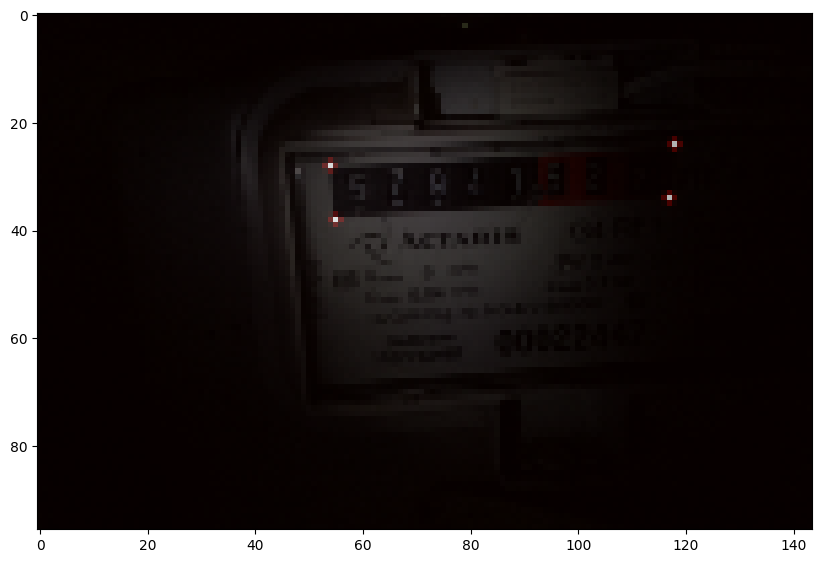

In [65]:
for batch_num, (images, heatmaps) in enumerate(train_dataset):
    # Nimm das erste Bild aus dem Batch (z. B. das erste Bild und Heatmap)
    image = images[0].numpy()
    heatmap = heatmaps[0].numpy()# Wandeln Sie Tensor in NumPy-Array um

    # Visualisiere das Heatmap-Bild des Labels
    fig, axes = plt.subplots(1, 1, figsize=(10, 8))  # Größe angepasst, um beide Bilder nebeneinander zu zeigen
    
    axes.imshow(image, aspect="auto")

# Heatmap mit Transparenz über das Bild legen
    axes.imshow(heatmap, cmap="hot", alpha=0.7) 
    break

## Evaluation des Modells
Die Evaluation über die Metriken _mse_ oder _accuracy_ von Tensorflow macht nicht viel Sinn. Für die Bewertung des Modells ist der _mse_ zu Abstrakt und nicht greifbar. Er soll klein sein, aber es fehlt jegliche Referenz, welcher Wert gut oder schlecht ist. _Accuracy_ als Metrik von Tensorflow macht nicht viel Sinn, da sie bei dem untrainierten Modell schon ca.88% Genauigkeit angezeigt hat. Dies macht aber wenig Sinn, wenn die Label Heatmaps mit den Prediction Heatmaps verglichen werden. 

Aus diesem Grund wurden eigene Funktionen zur Bewertung der Genauigkeit auf unbekannte Daten entwickelt.
#### Das Vorgehen
Der Validierungsdatensatz wird durch iteriert und für jedes Bild die Prediction sowie die Label Heatmap betrachtet. 
1. Punkte mit den höchsten Werten aus den beiden Heatmaps auslesen.
2. Beide Listen korrigieren, so dass nur noch 4 Punkte enthalten sind.
3. Vergleich der Koordinaten aus Label mit Predicteten Koordinaten.

Die einzelnen Schritte werden jeweils über den Funktionen ausführlich beschrieben.






## Ertellen der Callback Funktion um in den Trainingsprozess einzugreifen 
#### early_stopping:
Dient zum frühzeitigen trainingsabbruch falls _validation mse_ sich innerhalb von 5 Epochen nicht bessert. Es werden die Gewichte aus der Epoche mit dem besten Trainingsgewichte genommen. 
#### reduce_learningrate:
Die Lernrate wird mit den Faktor 0.1 um eine Zehnrpotenz verkleinert, wenn sich die _validation mse_ innerhalb von 3 Epochen nicht bessert.
#### tensorboard:
Protokolliert die Trainingsmetriken nach jeder Epoche für eine Visuelle Darstellung des Trainings über Tensorboard

### start_tensorboard
Startet Tensorboar über einen subprozess,so dass die Metriken aus dem Training direkt mitverfolgt werden können, sobald die Funktion aufgerufen wird.

In [66]:
import subprocess


def create_callback(log_dir="./logs", patience_early_stopping=5, patience_lr=3):

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_mse",
        patience=patience_early_stopping,
        restore_best_weights=True,  # Setzt die besten Gewichte zurück
        verbose=1,
    )

    # ReduceLROnPlateau Callback (Reduziert die Lernrate, wenn sich der Validierungsverlust nicht verbessert)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_mse",
        factor=0.1,  # Lernrate wird um den Faktor 0.5 reduziert
        patience=patience_lr,  # Wie viele Epochen warten, bevor die Lernrate reduziert wird
        verbose=1,
    )

    # TensorBoard Callback (Protokolliert das Training für TensorBoard)
    tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,  # Protokolliert Histogramme für die Gewichtsinformationen
        update_freq="epoch",  # Protokolliert die Metriken nach jeder Epoche
    )

    # Alle Callbacks in einer Liste zusammenfassen
    return [early_stopping, reduce_lr, tensorboard]


my_callbacks = create_callback()


# TensorBoard über subprocess starten
def start_tensorboard(log_dir):
    command = f"tensorboard --logdir={log_dir}"
    subprocess.Popen(command, shell=True)

### Definieren des CNN 
Das Modell ist aufgebaut nach dem U-Net Prinzip. Das Netz hat eine symmetrische Architektur mit einem Encoder (Downsampling-Pfad) und einem Decoder (Upsampling-Pfad), die durch einen Bottleneck-Bereich verbunden sind. Es kombiniert lokale Merkmale (über den Encoder) mit globalem Kontext (über den Decoder) durch Skip-Verbindungen.
#### Encoder:
Der Encoder besteht aus 4 Stufen, welche jeweils aus einem Conv2D-Layer und einem Maxpooling-Layer bestehen. 

Die Conv2D-Layer sorgen für die Extraktion der Merkmale mit einer ___relu___ für die nicht linearität. Die Maxpooling-Layer sorgen für die verkleinerung der Featuremaps um die Datenmenge verkleinern. Die Anzahl der Kanäle wird von der ersten zur letzten Schicht des Encoders von 8 auf 32 erhöht. Am Ende des Encoders sind die Featuremaps klein, aber reich an Informationen.
#### Bottleneck
Der Bottleneck verbindet den Encoder mit dem Decoder. Er besteht aus einer Stufe mit einem Conv2D-Layer mit 64 Kanälen. Dies ist der abstrakteste Teil der Repräsentation, da die Featuremaps hier am kleinsten sind. Anschließend erfolgt das Upsampling im Decoder.
#### Decoder
Der Decoder besteht aus 4 Stufen, welche jeweils aus einem Conv2DTranspose-Layer und einem Concatenate-Layer bestehen. Gefolgt in Stufe 5 von 2 Conv2D-Layern. 

Die Conv2DTranspose-Layer sind eine Mischung aus Conv2D-Layer und einem umgekehrten Maxpooling-Layer. Sie sorgen für eine Vergrößerung der Featuremap (komplementär zum Maxpooling) und haben dazu noch Filter kanäle in der Ausgabe. Die Anzahl der Kanäle geht von 64 auf 32 und in der 4 Stufe wieder auf 64. 

Die Concatenate-Layer sorgen für den erhalt wichtiger Details, da Informationen aus der dazugehörigen Encoderschicht direkt in den Decoder übergeben werden, ohne dass sie durch bspw. Maxpooling verloren gehen können. Am Ende des Up-samplings ist die Featuremap wieder in der ursprünglichen Auflösung vorhanden und durchläuft noch zwei Conv2D-Layer zur abschließenden Filterung mit 32 Kanälen. 
#### Ausgabe 
Die Ausgabeschicht besteht aus einem Conv2D-Layer. Sie wandelt die Featuremaps in eine Heatmap mit einem Kanal um. Die Sigmoid Funktion stellt sicher, dass die Werte der Heatmap zwischen 0 und 1 liegen. Diese Werte repräsentieren die Wahrscheinlichkeit, ob an dieser Pixelkoordiante eine Ecke im Bild ist. 



In [67]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import HeNormal


def unet_for_heatmaps(input_size=(None, None, 3), num_classes=1):
    inputs = layers.Input(input_size)

    # Encoder: Downsampling (Contracting Path)
    c1 = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(p2)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(p3)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(p4)

    # Decoder: Upsampling (Expanding Path)
    u6 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(c5)
    u6 = layers.concatenate([u6, c4], axis=-1) 

    u7 = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same")(u6)
    u7 = layers.concatenate([u7, c3], axis=-1)

    u8 = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same")(u7)
    u8 = layers.concatenate([u8, c2], axis=-1)

    u9 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(u8)
    u9 = layers.concatenate([u9, c1], axis=-1)
    c9 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(u9)
    c9 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(c9)

    # Output layer: Mehrkanalige Heatmap-Ausgabe
    outputs = layers.Conv2D(num_classes, (1, 1), activation="sigmoid", padding="same")(c9)

    model = models.Model(inputs, outputs)

    return model


### Erstellen des Modells 
Das  Modell wird erstellt. Als Optimizer wird Adam gewählt, mit einer Lernrate von 0.1 als Startwert. Dieser hilft große Änderungen am Anfang durchzuführen und wird durch die Callback Funktion ___reduce_lr___ verkleinert wenn nötig. Als loss wird die binary corssentropy genutzt.Sie eignet sich gut, weil sie die Wahrscheinlichkeit eines Pixels, zur Zielklasse zu gehören, bewertet. Als Metric wird der Mean squared Error gewählt da dieser sich gut für kontinuierliche Zielwerte eignet und Pixelweise arbeitet.

Anschließend erfolgt eine Model Zusammenfassung.

In [68]:
# Modell erstellen
model = unet_for_heatmaps()
# Optimizer auswählen
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
# Modell kompilieren
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["mse"])
# Modell zusammenfassen
model.summary()

### Modelltraining
Das Training wird 100 Epochen durchgeführt. Anschließend wird Tensorboard gestartet, um das Training und die Metriken mitzuverfolgen. Es wird mit dem Trainingsdatensatz trainiert und der definierte Callback mit eingebunden, sowie der Validierungsdatensatz, damit der Callback reagieren kann.

In [69]:
# model.fit(
#     train_dataset,
#     epochs=100,
#     verbose=1,
#     callbacks=my_callbacks,
#     validation_data=validation_dataset,
# )
# # Starte TensorBoard
# log_dir = "./logs"
# start_tensorboard(log_dir)

# Browserzugriff auf TensorBoard:
- Nachdem du TensorBoard gestartet hast, öffne einfach deinen Webbrowser und gehe zu http://localhost:6006, um die TensorBoard-Oberfläche anzuzeigen.

### Speichern der Netzparameter und der Struktur in Datei "trainiertes_modell.h5"
So kann der neue Trainingserfolg und die damit verbundenen neuen Parameter gespeichert werden und später auf sie zugegriffen werden.

In [70]:
# speichern des trainierten modells mit allen parasmetern
#model.save("modell.h5")

### Laden der zuvor gespeicherten Modellparameter in das Netz 
Die gespeicherten Parametern können in das Modell geladen werden, wenn sie beispielsweise nach Neustart des Programms zurückgesetzt wurden.

In [71]:
# gespeichertes modell laden
model = tf.keras.models.load_model("modell.h5")

## Evaluation des Modells
Die Evaluation über die Metriken _mse_ oder _accuracy_ von Tensorflow macht nicht viel Sinn. Für die Bewertung des Modells ist der _mse_ zu Abstrakt und nicht greifbar. Er soll klein sein, aber es fehlt jegliche Referenz, welcher Wert gut oder schlecht ist. _Accuracy_ als Metrik von Tensorflow macht nicht viel Sinn, da sie bei dem untrainierten Modell schon ca.88% Genauigkeit angezeigt hat. Dies macht aber wenig Sinn, wenn die Label Heatmaps mit den Prediction Heatmaps verglichen werden. 

Aus diesem Grund wurden eigene Funktionen zur Bewertung der Genauigkeit auf unbekannte Daten entwickelt.
#### Das Vorgehen
Der Validierungsdatensatz wird durch iteriert und für jedes Bild die Prediction sowie die Label Heatmap betrachtet. 
1. Punkte mit den höchsten Werten aus den beiden Heatmaps auslesen.
2. Beide Listen korrigieren, so dass nur noch 4 Punkte enthalten sind.
3. Vergleich der Koordinaten aus Label mit Predicteten Koordinaten.

Die einzelnen Schritte werden jeweils über den Funktionen ausführlich beschrieben.






#### 1. Punkte mit den höchsten Werten aus den beiden Heatmaps auslesen:
 Das geschieht mit der Funktion _point_detection_ diese sammelt jeweils die 50 Punkte mit den höchsten Werten aus der Heatmap in einer Liste. Werden nur die 4 höchsten Punkte gesammelt, kann es vorkommen das benachbarte Pixel als 2 verschiedene Eckpunkte interpretiert werden. Der Wert 50 wurde durch Versuche ermittelt und hat sich bis jetzt als beste Anzahl bewährt. Anschließend wird die Liste nach x- und y-Wert sortiert.

In [72]:
def pointdetection(prediction, heatmap):    
    # Anzahl der Punkte definieren
    number_of_points = 50

    top_4_points = np.unravel_index(
        np.argsort(prediction, axis=None)[-number_of_points:],
        prediction.shape,  # suche die höchsten punkte
    )
    top_4_points = list(
        zip(
            top_4_points[1], top_4_points[0]
        )  # erstelle eie liste im format [(x1,y1), (x2,y2)]
    )
    top_4_points = sorted(
        top_4_points,
        key=lambda x: (
            x[0],
            x[1],
        ),  # Sortiere nach beiden Koordinaten (zuerst x, dann y)
    )

    heatmappoints = np.unravel_index(
        np.argsort(heatmap, axis=None)[-number_of_points:],
        heatmap.shape,  # suche die 4 höchsten punkte
    )
    heatmappoints = list(
        zip(
            heatmappoints[1], heatmappoints[0]
        )  # erstelle eie liste im format [(x1,y1), (x2,y2)]
    )
    heatmappoints = sorted(
        heatmappoints,
        key=lambda x: (
            x[0],
            x[1],
        ),  # Sortiere nach beiden Koordinaten (zuerst x, dann y)
    )
    return top_4_points, heatmappoints

Hilsfunktion zur Berechnung des Abstandes zweier Pixelpunkte

In [73]:
# Funktion zur Berechnung der euklidischen Distanz zwischen zwei Punkten
def calculate_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

#### 2. Beide Listen korrigieren, so dass nur noch 4 Punkte enthalten sind:
 Das wird mit der Funktion _listcorrection_ erreicht. Sie nimmt den ersten Punkt in der Liste (50 Einträge) und fügt ihn der korrekten Liste _valid_points_ hinzu. Dieser erste Eintrag sind die Koordinaten für den ersten predicteten Eckpunkt. Anschließend wird berechnet, welcher der nächsten Einträge einen Mindestesabstand von 8 Pixeln hat. Dieser Punkt wird _valid_poinst_ angehängt. Dieser Vorgang wiederholt sich bis die Liste eine Länge von 4 hat oder alle Punkte durchiteriert wurden. Anschließend wird sie wieder nach x- und y-Wert sortiert. So wird jedem predicteten Eckpunkt nur eine Koordinate zugewiesen. Benachbarte Pixel, welche die beiden höchsten Werte in der Heatmap haben werden nun nicht mehr als als zwei Eckpunkte interpretiert, weil diese den Mindestabstand unterschreiten. 

Das Problem an diesem Algorythmus liegt, der Sortierung der Liste nach den Koordinatenwerten. Bei der _listcorrection_ werden immer die ersten Punkte, welche den Mindestabstand einhalten der korrekten Liste _valid_points_ angehängt. Das heißt, für jeden neu betrachteten Bereich in einem Bild in dem ein Eckpunkt sein kann wird nicht der Koordinatenpunkt genommen welcher die höchste Wahrscheinlichkeit hat sondern derjenige mit den kleinsten Koordinatenwerten (aufgrund Sortierung). Dies verfälscht das Ergebnis und verschiebt die Eckpunkte künstlich nach links oben bzw. zum Koordinatenursprung. 

In [74]:
def listcorrection(list, list_length=4):
    min_distance = 8  # Mindestabstand in Pixeln
    valid_i = 0
    list_i = 0
    valid_points = [list[0]]

    # Solange die Liste weniger als 4 Punkte hat
    while len(valid_points) < list_length and list_i < len(list):
        distance = calculate_distance(valid_points[valid_i], list[list_i])

        if distance > min_distance:
            valid_points.append(list[list_i])
            valid_i += 1
            list_i += 1
        else:
            list_i += 1

        valid_points = sorted(
            valid_points,
            key=lambda x: (
                x[0],
                x[1],
            ),  # Sortiere nach beiden Koordinaten (zuerst x, dann y)
        )
    return valid_points

#### 3. Vergleich der Koordinaten aus Label mit Predicteten Koordinaten: 
Die Funktion _validate_prediction_ sortiert ein letztes mal die Listen für Label und Prediction, damit ein sinnvoller Vergleich der Koordinaten erfolgen kann. Nun werden die Punkte der Prediction den Punkten des Labels nach Abstand zugewiesen. So wird der eine falsche Zuweisung von Punkten aufgrund von minimalen Predictionfehlern verhindert. Mögliches Problem was zu der Interpretation einer falschen Prediction führt:

Labelkoordinaten______:[(32,34),(48,71),(60,21),(61,59)]

Predictionkoordinaten: [(32,34),(48,71),(61,59),(62,21)]

Dafür werden die Abstände von Labelpunkt zu allen Predictionpunkten berechnet und in der Liste _distance_list_ gespeichert, der Index des kleinsten Wertes aus dieser Liste entspricht dem Index des Predictionpunktes der zum Labelpunkt gehört. Wenn alle Punkte die richtige Reihenfolge haben, werden die Abständer berechnet. Liegen alle Punkte im maximalen Abstand von 5 Pixeln gilt die prediction als korrekt und eine 1 zurückgegeben, falls nicht eine 0. Es werden alle Punkte aufsummiert und durch die Nummer der Durchläufe dividiert. Dies liefert eine den Prozentwert der richtigen Predictions. Predictions die weniger Punkte vorhersagen als im Label vorhanden werden grundsätztlich als Falsch angenommen.

Das Problem, dass zu wenige Punkte Predicted werden tritt meist auf, wenn der tatsächliche Eckpunkt knapp außerhalb des Bildes liegt, aber in der Label Heatmap noch ein Bruchteil der Gaußverteilung des Eckpunktes im sichtbaren Bereich liegen. Der der vorgestellte Algorythmus interpretiert diesen Bereich als Punkt und ordnet der Label Heatmap einen Punkt zuviel zu.


In [75]:
# Validierungsfunktion
def validate_prediction(pred_list, label_list, max_distance=5):
    correct_points = 0
    label_idx = 0
    correct_pred_list = [None] * len(label_list)
    distance_list = []

    for o in range(len(label_list)):

        for i in range(len(label_list)):
            distance_list.append(calculate_distance(label_list[label_idx], pred_list[i]))  # Berechnung des Abstandes und speicherung in liste

            if len(distance_list) == len(label_list):
                min_index = distance_list.index(min(distance_list))  # Der Index des kleinsten Wertes ist der Index für den dazu gehörigen Wert
                correct_pred_list[label_idx] = pred_list[min_index] # Der Punkt mit kleinstem Abstand wird in die korrekte Liste hinzugefügt
                distance_list = []
                label_idx += 1

    for u in range(len(label_list)):
        dist = calculate_distance(
            correct_pred_list[u], label_list[u] # Abstandsberechnung der Punkte
        )
        if dist > max_distance:  # Ein Punkt liegt außerhalb der zulässigen Abweichung
            correct_points += 0
        else:
            correct_points += 1  # Ein Punkt liegt innerhalb der zulässigen Abweichung

    if correct_points == len(label_list):  # Alle Punkte sind korrekt
        
        return [correct_pred_list], 1
    else:
        return correct_pred_list, 0

Im folgenden Block werden die vorher definierten Funktionen aufgerufen und der Validirungsdatensatz durchiteriert.
Für jedes 20. Bild wird die Prediction Heatmap über das Input Bild gelegt. am Ende wird eine Grafik dargestellt über den Verlauf der Validierung bzw. der Genauigkeit.

2025-01-09 14:44:03.678097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2025-01-09 14:44:03.678357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [100]
	 [[{{node Placeholder/_1}}]]


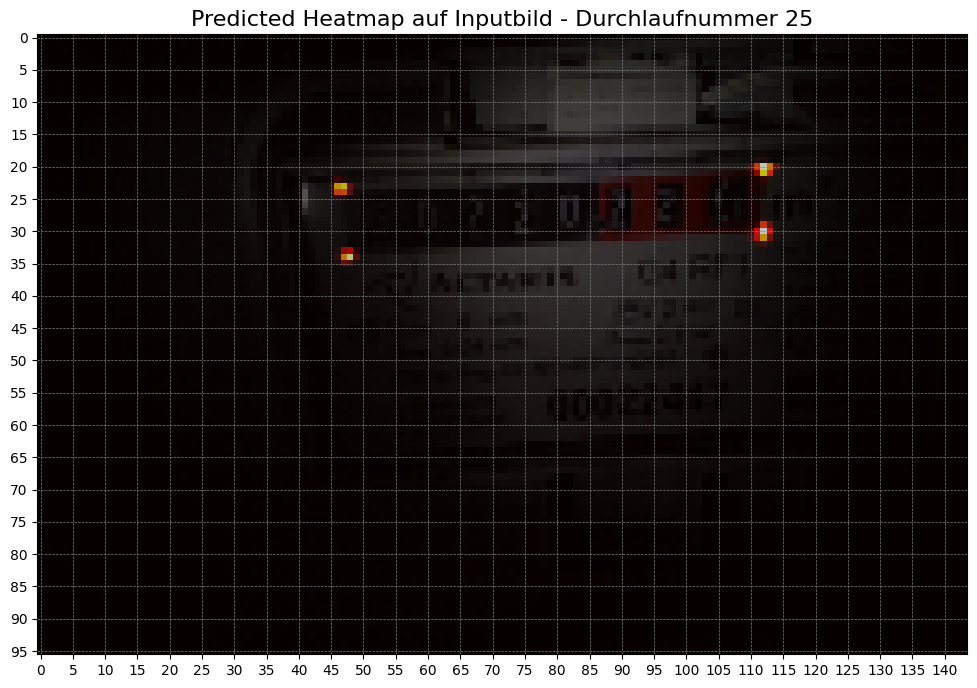

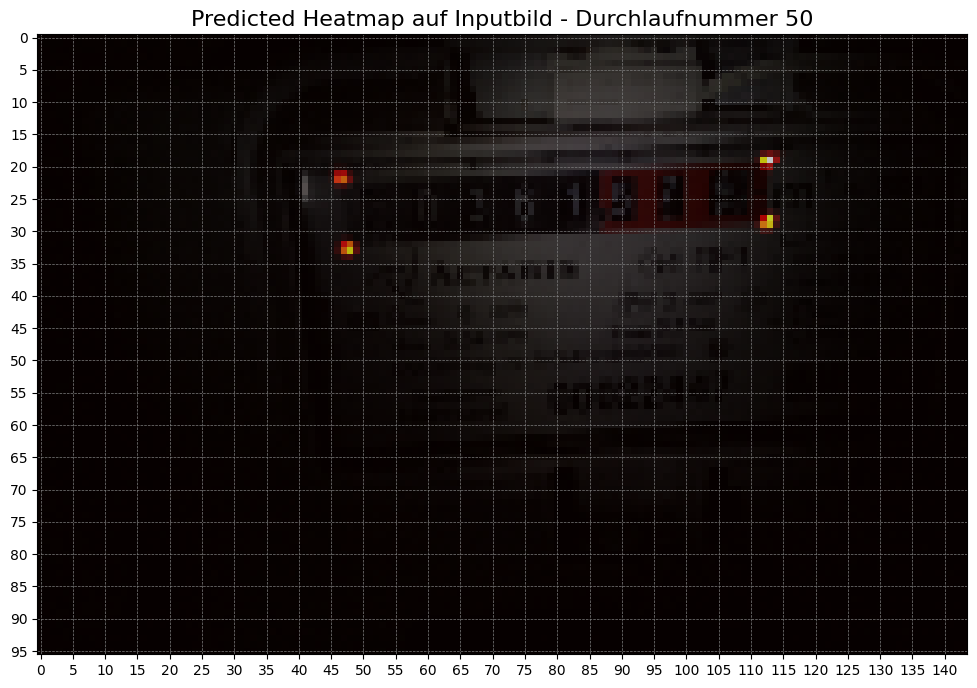

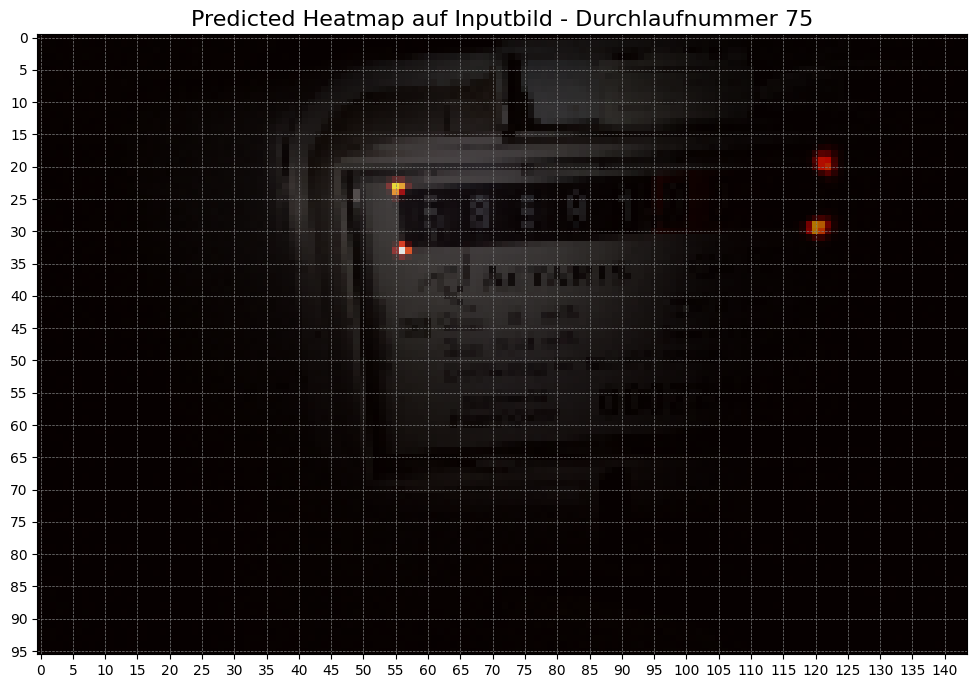

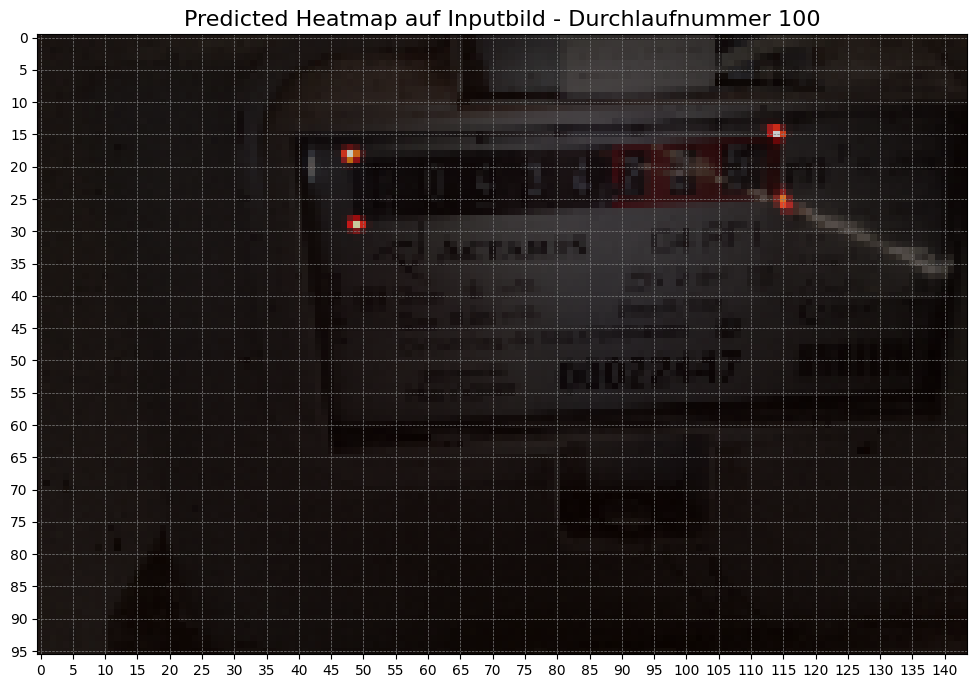

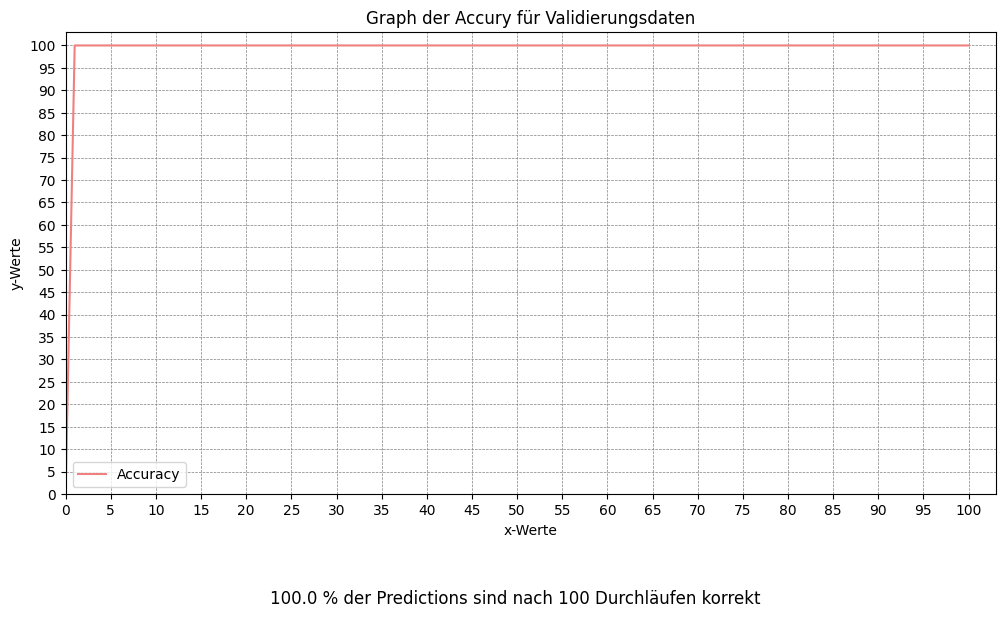

In [76]:
from matplotlib.ticker import MultipleLocator
import logging
import sys
import os

# Initialieseren der Start Bedingung
correct_predictions = 0
x_werte=[0]
y_werte=[0]

for batch_num, (images, heatmaps) in enumerate(validation_dataset):

    image = images[0].numpy()  # Wandeln von Tensor in NumPy-Array um
    heatmap = heatmaps[0].numpy()  # Wandeln von Tensor in NumPy-Array um

    # Umleiten der Standardausgabe
    sys.stdout = open(os.devnull, "w")
    prediction = model.predict(images) # Predicton erstellen
    # Wiederherstellen der Standardausgabe
    sys.stdout = sys.__stdout__

    prediction = prediction[0]
    prediction_image = prediction[:, :, :]

    # Bestimmung der Punkte aus Label und Prediction
    prediction_points, heatmappoints = pointdetection(prediction, heatmap)

    # Korrektur der Liste aus den 50 Punkten werden die höchsten 4 punkte mit mindest abstand von 10 pixeln gewählt
    heatmappoints = listcorrection(heatmappoints, 4)
    prediction_points = listcorrection(prediction_points, len(heatmappoints))

    # Berechnung der korrekt detektierten Ecken wenn die Anzahl an Punkten aus Label und Prediction stimmen
    if len(prediction_points) == len(heatmappoints):
        # Berechnung der prozuentalen Anteil an korrekten Predictions
        prediction_points, correct_prediction = validate_prediction(prediction_points, heatmappoints)
    else: # Wenn Anzahl der Punkte nicht über einstimmt -> Falsche Prediction bzw. Fehler     
        correct_prediction=0

    # Berechnung der prozuental richtigen Predictions
    correct_predictions += correct_prediction # Wenn richtige Prediction wird die gesamtanzahl der richtigen Predictions um 1 erhöht
    correct_validations = 100 * (correct_predictions / (batch_num + 1))

    # Listen für Graphik
    x_werte.append(batch_num+1)
    y_werte.append(correct_validations)

    if (batch_num+1)%25==0: # Alle 20 bilder visuelle Ausgabe der Heatmap über Bild und Informationen

        # Visualisiere das Heatmap-Bild
        fig, axes = plt.subplots(1, 1, figsize=(12, 10))
        axes.set_title(
            f"Predicted Heatmap auf Inputbild - Durchlaufnummer {batch_num + 1}", fontsize=16
        )  # Größe angepasst, um beide Bilder nebeneinander zu zeigen
        axes.imshow(image, aspect="auto")
        # Heatmap mit Transparenz über das Bild legen
        axes.imshow(prediction_image, cmap="hot", alpha=0.7)
        axes.grid("on") 
        axes.grid(color="gray", linestyle="--", linewidth=0.5)
        axes.xaxis.set_major_locator(MultipleLocator(5))  # Abstände der x-Ticks auf 10 setzen
        axes.yaxis.set_major_locator(MultipleLocator(5))
        plt.show()  


    if batch_num==len(validation_dataset)-1:
        
        # Graph erstellen
        plt.figure(figsize=(12, 6))

        plt.plot(x_werte, y_werte, label="Accuracy", color="lightcoral", marker=None)  # Linie und Marker hinzufügen

        # Titel und Achsenbeschriftungen
        plt.title("Graph der Accury für Validierungsdaten")
        plt.xlabel("x-Werte")
        plt.ylabel("y-Werte")
        plt.xlim(0, 103)
        plt.ylim(0, 103)
        plt.gca().xaxis.set_major_locator(MultipleLocator(5))  # Abstände der x-Ticks auf 10 setzen
        plt.gca().yaxis.set_major_locator(MultipleLocator(5))  # Abstände der y-Ticks auf 20 setzen

        plt.grid(True, which="both", linestyle="--", color="gray", linewidth=0.5)
        plt.figtext(
            0.5,
            -0.05,
            f"{correct_predictions:.1f} % der Predictions sind nach 100 Durchläufen korrekt",
            ha="center",
            va="top",
            fontsize=12,
        )

        # Legende hinzufügen
        plt.legend()
        # Graph anzeigen
        plt.show()

### Ausblick/Fazit 
Das Modell erreicht sehr gute Ergebnisse zwischen 90% und 100%. Ein großteil der fehlerhaften Prediction lässt sich auf die schlechte Genauigkeit des Validierungsalgorythmus zurückführen. Liegen Eckpunkte des Inputbilds einige wenige Pixel außerhalb des Bildes kann das Modell dafür richtiger Weise keine Prediction liefern. Jedoch wird dieser Punkt im Label zum Teil dargestellt, da der Gausfilter Pixeln, in einem bestimmten Radius um den Eckpunkt, relativ hohe Werte zuweist. Diese werden vom Algorythmus erkannt und als Eckpunktkoordinate im Label gesetzt. Beim Vergleich der Länge von Prediction und Label, fehlt der Prediction ein Eintrag. Dies führt zu einer Wertung als falsche Prediction, wobei es sich jedoch um einen systematischen Fehler handelt. Dieser systematische Fehler kann umgangen werden, wenn sichegestellt wird, dass alle Eckpunkte im Bild liegen. Führt man keine Rotation durch kommt das Modell auf 100% Genauigkeit.

Der Fehler kann durch Ausbesserung des Codes vermieden werden oder durch Sicherstellung, dass alle Ecken im Bild sind. Man könnte den Code so anpassen, dass Werte, welche in die Liste aufgenommen werden, abhängig sind von ihrer Größe bzw. sie einen bestimmten Schwellenwert überschreiten müssen. Das würde schon einen Teil der Punkte aussortieren. Eine Verbesserung wäre nicht die Punkte zu sortieren und die Reihenfolge abhängig von der Wahrscheinlichkeitswerten der Koordinaten. Dann müsste der Vergleich nicht nur zwischen nächster Koordinate und letzter Koordinate stattfinden, sondern zwischen nächster Koordinate und aller bisherigen Koordinaten bevor sie in die korrekte Liste aufgenommen wird.

Im Anschluss könnte man das Projekt weiterführen, für auschneiden des Auslesefeldes und Entzerrung, sowie Zahlenfeld mit Zahlenerkennung. 

### Quellen
Zur Erstellung des Projektes wurden ausschließlich ChatGPT und die Beratungen und Implementierungen von Herrn Prof. von Marcard genutzt. 

Der benutzte Datensatz stammt ebenfalls von Herrn Prof. von Marcard. Dieser ist nicht öffentlich und wurde persönlich an uns übermittelt.